# physics -- Quick Start

physics is a package with helper functions for working with quantities
and formatting uncertain values.  This Quick-start tutorial seems to have become a rather long read ... sorry :-/

You can download the [Notebook](quickstart.ipynb) too.

## Requirements

python modules:

* numpy
* scipy
* [quantities](https://pythonhosted.org/quantities/user/tutorial.html)

other (optional):

* pdflatex
* pdfcrop (for Debian/Ubuntu in texlive-extra-utils)
* ImageMagick, wand python module

With pdflatex is used to create tables.  With pdfcrop, ImageMagick and `wand` those tables are displayed inline in Jupyter.

## Install

0. get source from https://github.com/tychon/physics

       git clone https://github.com/tychon/physics.git

0. go to project root and install with

       $ python3 setup.py develop --user

   With `'develop'` the files will not be copied to your local package directory and the interpreter will load modules from the project directory.

To uninstall run

    $ pip3 uninstall physics

## Intro

The physics module has two modules named `fit` and `fmt`.  The `fit` module contains an abstraction of scipy fit functions, the `fmt` module formats values with uncertainty and unit for `print()` or as tex tables and as PDF.

## import

Standard imports are `numpy`, `quantities` and following physics modules:

In [1]:
import numpy as np
import quantities as pq

from physics.fit import *
from physics.fmt import *

import matplotlib.pyplot as plt
%matplotlib inline

Using the star is generally not recommended.  The physics package tries to save you some work, so importing all the functions is just for convenience.

## Formatting quantities

The `fmt` module exports the following functions with `__all__`

* `fmtuncert(value, uncert, decimals, power, ...)`
* `fmtquant`: similar to `fmtuncert` but with quantities
* `fmtquant_vec`: vectorized version of fmtquant
* `fmttable`: format data as tex
* `printtable`: format data as tex and create PDF

### `fmtuncert`

The `fmtuncert` function tries to display your value in the most sensible way.  It does not support quantities, see `fmtquant`.

The number of visible digits defaults to four significant digits when no uncertainty is given:

In [2]:
print(fmtuncert(np.pi))
print(fmtuncert(np.exp(1) * 100))

3.142
271.8


Scales to a power of ten if the value is larger than 10000 or smaller than 0.01:

In [3]:
print(fmtuncert(2998e5)) # speed of light in m/s
print(fmtuncert(0.001264)) # liters of blood in 16g mouse
print(fmtuncert(0)) # liters of blood in computer mouse

2.998 10**8
1.264 10**-3
0.0


When an uncertainty is given, the value is rounded to two significant digits of the uncertainty.  When a power of ten is appended, the value is surrounded by parentheses:

In [4]:
print(fmtuncert(0.862551243, 0.00424990)) # weight of an M&M in grams
print(fmtuncert(1350, 23)) # distance to the Orion Nebula an ly
print(fmtuncert(1277e13, 22e13)) # distance to Orion Nebula in km

0.8626 +- 0.0042
1350 +- 23
(1.277 +- 0.022) 10**16


In [5]:
# corner case: uncert == 0 => four significant digits
print(fmtuncert(2998e5, 0)) # speed of light again
# special values
print(fmtuncert(0.3, np.nan))
print(fmtuncert(0.3, np.nan, nanempty=True)) # nothing
print(fmtuncert(-np.inf, 2))

(2.998 +- 0.000) 10**8
0.3000 +- nan

-inf +- 2.0


Using the third argument (named `decimals`), you can overwrite the number of decimal places to show.  The fourth argument lets you control the power:

In [6]:
print(fmtuncert(0.862551243, 0.00424990, 6))
print(fmtuncert(0.862551243, 0.00424990, 2))
print(fmtuncert(0.862551243, 0.00424990, 1, -3))
print(fmtuncert(0.862551243, 0.00424990, power=-6))

0.862551 +- 0.004250
0.86 +- 0.00
(862.6 +- 4.2) 10**-3
(862551 +- 4250) 10**-6


With the `significance` argument you can round your number and uncertainty to a power of ten.  This is useful for large numbers if you don't want to display an order, but hide misleading accuracy:

In [7]:
print(fmtuncert(56284.3, 1921, power=0))
print(fmtuncert(56284.3, 1920, power=0, significance=2))

56284 +- 1921
56300 +- 1900


With `pm` you can control the delimiter between the value and the uncertainty and with `ten` the delimiter between the uncertainty or value and the order.  With `tex=True` curly braces are shown for the order.

In [8]:
print(fmtuncert(1350, 23, pm=r' \pm ', ten=r' \cdot 10^'))
print(fmtuncert(1277e13, 22e13, pm=r' \pm ', ten=r' \cdot 10^', tex=True))

1350 \pm 23
(1.277 \pm 0.022) \cdot 10^{16}


### fmtquant

`fmtquant` is a wrapper for `fmtuncert` and handles quantities.  The units are shown trailing the order of magnitude.  The uncertainty is rescaled to units of the value to avoid confusion:

In [9]:
print(fmtquant(pq.c.simplified))
print(fmtquant(0.862551243 * pq.g, 0.00424990 * pq.g))
print(fmtquant(0.862551243 * pq.g, 4.24990 * pq.mg))
print(fmtquant(pq.c.simplified, units=False)) # hide units

2.998 10**8 m/s
(0.8626 +- 0.0042) g
(0.8626 +- 0.0042) g
2.998 10**8


The `UncertainQuantity` class of `quantities` is not and probably will not be supported any time soon, since it does not (any by principle can not) support error propagation for non-trivial calculations.

### comparequant

If you want to compare quantities in respect to their uncertainties (for example fit results to literature values) use

    comparequant(v1, v2,
                 err1=None, err2=None,
                 names=None)

where `v1` and `v2` are lists of quantities where every i-th value has the same units.  `err1` and `err2` are one-sigma errors an can be omitted (default to zero).  The last optional argument `names` is a list of names (as strings) for each row.

It prints in four columns the names, the two values and the deviation calculated by

$\delta = \frac{\lvert v_2 - v_1\rvert}{\sqrt{\Delta v_1^2 + \Delta v_2^2}}$

The return value of `comparequant()` is a list of these deviations.

In [10]:
v1 = [592.7 * pq.Hz, 0.02966 / pq.s]
v1err = [5.0 * pq.Hz, 0.00035 / pq.s]

v2 = [600.0 * pq.Hz, 0.03 / pq.s]

dev = comparequant(v1, v2,
                   v1err, None,
                   names=['f0', 'd'])

print()
print(dev)

f0 |        (592.7 +- 5.0) Hz |        (600.0 +- 0.0) Hz |  1.460 σ
 d | (0.02966 +- 0.00035) 1/s | (0.03000 +- 0.00000) 1/s | 0.9714 σ

[array(1.4599999999999909) * dimensionless, array(0.9714285714285715) * dimensionless]


## Tables

`physics` will try to display the table inline.  For that it needs `pdfcrop` and the `wand` module.  If it can't find one of them, displaying tables is deactivated.

I will only show you how to use `printtable()`, since all other functions are just helper functions to this one.  First we generate some fictional data, for example the measurement of a damped rotation:

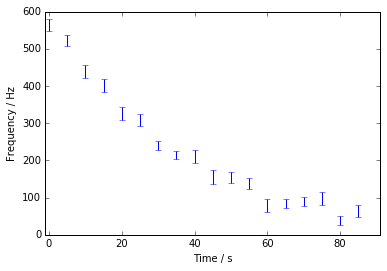

In [11]:
t = np.arange(0, 90, 5) * pq.s
d = 0.03 / pq.s # dampening constant
f = 600 * np.exp(-d * t) * pq.Hz

# gaussian distribution of measured values
# sadly np.random is not yet supported by quantities
ferr = np.random.uniform(10, 20, len(f)) * pq.Hz
f = np.random.normal(f, ferr.magnitude) * pq.Hz

plt.figure(1)
plt.errorbar(t, f, fmt=' ', yerr=ferr)
plt.xlabel(r"Time / s")
plt.ylabel(r"Frequency / Hz")
plt.xlim([-1, 91])
plt.show()

Now we can generate a table displaying this data.  I have to admit, that the `printtable` function is not very easy to use, since it has these long tuples.

First the table is formatted to LaTeX, which is written to a file and then compiled using `pdflatex` in a subprocess.  If `pdflatex` returns with 0 as return code, the table is cropped from DIN-A4 and displayed in Jupyter.

The first argument of the function is all the data to be displayed.  It is a list of tuples.  Every tuple is one column and can have a length from two to six values.

If the tuple has a length of 2 or 3

    (heading, values, fun=str)

`heading` is LaTeX to be displayed in the table header.  `values` is a list of nearly anything.  If `fun` is not given, `str` is used to convert the values in `values` to LaTeX.  `fun` can be any function taking one value and returning a string.

The more interesting tuples are of length 4 to 6:

    (heading, values, uncert, decimals, power=0, significance=None)

`heading` is the column header again. `values` should be a numpy ndarray with data and `uncert` can be a single value or a ndarray of the same length as `values`.  `uncert` can be `None` if no uncertainty is known (or the quantities have none).  `decimals` specifies the number of decimal places to show (obvious :-P).  `power` and `significance` have the same meaning as in `fmtuncert()`.


Here we go:

INFO: rescaling uncertainty for $f / kHz$
Compiling to table1.pdf


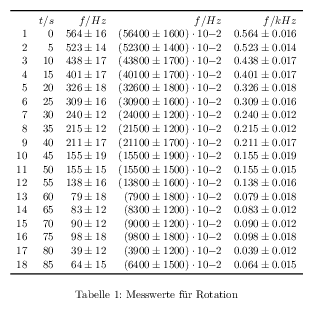

'table1'

In [12]:
printtable([("$t / s$", t, None, 0),
            ("$f / Hz$", f, ferr, 0),
            ("$f / Hz$", f, ferr, 0, -2, 0),
            ("$f / kHz$", f.rescale('kHz'), ferr, 3)],
          r"Messwerte f\"ur Rotation")

The `printtable()` function has some more arguments:

* `caption`: The caption for the table
* `tableno`: The table number (used for default file name too)
* `name`: A basename to use when creating files
* `columnformat`: A string of 'lcr' (left, center, right) giving the alignment of text in the columns.  You have to include the alignment for the leftmost index column!
* `index`: The index defaults to a enumeration of rows.  If supplied, it has to be a list of LaTeX strings and be of the same length as the longest data column.  The index can be suppressed with `index=None`

Another example:

Compiling to table2.pdf


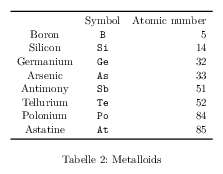

'table2'

In [13]:
number = [5, 14, 32, 33, 51, 52, 84, 85]
elsym = ['B', 'Si', 'Ge', 'As',
         'Sb', 'Te', 'Po', 'At']
elnames = ["Boron", "Silicon", "Germanium", "Arsenic",
           "Antimony", "Tellurium", "Polonium", "Astatine"]

printtable([("Symbol", elsym, lambda sym: r'\texttt{'+sym+'}'),
            ("Atomic number", number, None, 0)],
           r"Metalloids",
           tableno=2,
           columnformat='ccr',
           index=elnames)

If you want to keep the cropped table, pass `keepcropped=True` to `printtable()`.

## Fitting data

Again I will only show you `fitquant()` since it is the most useful function.

`fitquant()` is a wrapper handling quantities for `autofit()`.  In almost all cases you should be able to simply cram you data into `fitquant()` (or `autofit()` if you don't have quantities associated with it) and get some result.

Depending on the type of uncertainties you supply a fit algorithm is chosen and run.  Then some additional info like standard error of best fit parameters are calculated / estimated.

The used algorithms are:

* no xerr: `scipy.optimize.curve_fit` which in turn uses
  * unbounded: `scipy.optimize.leastsq` (Levenberg-Marquardt algorithm)
  * bounded parameters: `scipy.optimize.least_squares` (Trust Region Reflective algorithm)
    * *this requires at least version 0.17.0 of scipy*
* with xerr but no bounds: `scipy.odr.odr` (Levenberg-Marquardt algorithm)
* bounds and xerr not supported

The function arguments are:

    fitquant(fun, xdata, ydata, p0,
             xerr=None, yerr=None,
             bounds=None,
             pprint=True,
             full_output=False)

The first argument of the function is the model function.  It takes the independent variable (x) as first argument, then all the parameters and outputs one value (y).  It has to work on numpy ndarrays.

The second and third argument is the data to fit against.

`p0` is a list of initial guesses for the parmeters.  The units of the parameters are determined from these numbers too.

All following arguments are optional.

`xerr` and `yerr` are uncertainties (one sigma errors) for `xdata` and `ydata` (a scalar or ndarray of same length).  They must not contain values smaller or equal to 0.

With `bounds` you can restrict the parameters to ranges.  It is a list of `(min, max)` tuples for parameters.  Use `+/- np.inf` for `min` or `max` when there is no bound in that direction.  If parameters lie close to a bound, the estimated covariance matrix becomes singular (not good).

The fit result is printed out for you (unless you specify `pprint=False`).  The shown parameter names are taken from the model function argument names.

The function returns a 2-tuple: (1) a list of estimated parameters and (2) a list of standard errors for the parameters.  With `full_output=True` a 3-tuple is returned, where the third element is a dict with additional fit information (like the covariance matrix).

Here's an example:

Fitting [Hz] depending on [s]
    N=90, params=2, dof=88
    Method: curve_fit
    successful: True
    trf finished
    Residual variance: 1.0075777085
    Probability of fit: 46.0%
    Parameters:
      t0: (598.3 +- 3.7) Hz
      d: (0.02991 +- 0.00026) 1/s

f0 |        (598.3 +- 3.7) Hz |        (600.0 +- 0.0) Hz | 0.4503 σ
 d | (0.02991 +- 0.00026) 1/s | (0.03000 +- 0.00000) 1/s | 0.3527 σ

Results as lists:
param: [array(598.326278465989) * Hz, array(0.029907655542157765) * 1/s]
uncert: [array(3.716799767274664) * Hz, array(0.0002618143204319386) * 1/s]


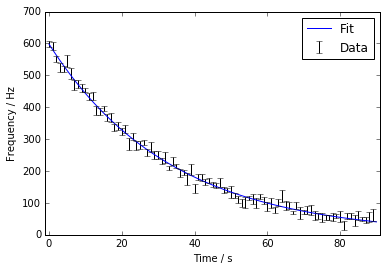

In [14]:
# some fictional data
t = np.arange(0, 90, 1) * pq.s
d = 0.03 / pq.s # dampening constant
f = 600 * np.exp(-d * t)
# gaussian distribution of measurements
ferr = np.random.uniform(5, 20, len(t)) * pq.Hz
f = np.random.normal(f, ferr.magnitude) * pq.Hz

# the model function with parameters t0 and d
def fun(t, t0, d):
    return t0 * np.exp(-d * t)

# the fit with initial parameters t0=520Hz and d=0.1/s
# with bounds (they aren't necessary, but that's how they work)
ps, perr = fitquant(fun, t, f, [520*pq.Hz, 0.1/pq.s],
                    yerr=ferr,
                    bounds=[(0, np.inf)*pq.Hz,
                            (0, np.inf)/pq.s])

print()
c = comparequant(ps, [600*pq.Hz, d], perr, names=['f0', 'd'])

print("\nResults as lists:")
print("param:", ps)
print("uncert:", perr)

# and a nice plot
plt.figure(1)
xs = np.linspace(0, 90, 300) * pq.s
plt.plot(xs, fun(xs, ps[0], ps[1]), '-', label="Fit")
plt.errorbar(t, f, fmt=' ', yerr=ferr,
             color='black', label="Data")
plt.xlabel(r"Time / s")
plt.ylabel(r"Frequency / Hz")
plt.xlim([-1, 91])
plt.legend(numpoints=1)
plt.show()

And another one with uncertainties in both directions:

Fitting [J] depending on [cm]
    N=50, params=1, dof=49
    Method: odr
    successful: True
    ['Sum of squares convergence']
    Residual variance: 0.9731856094604181
    Probability of fit: 52.6%
    Parameters:
      k: (1.967 +- 0.067) N/cm

k | (1.967 +- 0.067) N/cm | (2.000 +- 0.000) N/cm | 0.4912 σ


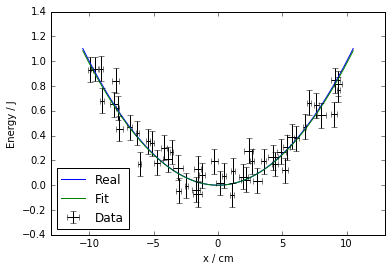

In [15]:
def V(x, k):
    return (0.5 * k * x**2).rescale('J')

xs = np.arange(-10, 10, 0.4) * pq.cm
k = 2 * pq.N / pq.cm # spring constant
Vs = V(xs, k)

# normal distribution in x and V
# sadly np.random is not yet supported by quantities
xerr = np.random.uniform(0.5, 2, len(xs))*0.2 * pq.cm
Verr = 0.1 * pq.J
xs = np.random.normal(xs, xerr.magnitude) * pq.cm
Vs = np.random.normal(Vs, Verr.magnitude) * pq.J

# the fit with initial parameters
ps, perr = fitquant(V, xs, Vs, [1*pq.N/pq.cm],
                    xerr=xerr, yerr=Verr)

print()
c = comparequant(ps, [k], perr, names=['k'])

# and a nice plot
plt.figure(1)
cont = np.linspace(-10.5, 10.5, 300) * pq.cm
plt.plot(cont, V(cont, k), '-', label="Real")
plt.plot(cont, V(cont, ps[0]), '-', label="Fit")
plt.errorbar(xs, Vs, fmt=' ',
             xerr=xerr, yerr=0.1*pq.J,
             color='black', label="Data")
plt.xlabel(r"x / cm")
plt.ylabel(r"Energy / J")
plt.xlim([-13, 13])
plt.ylim([-0.4, 1.4])
plt.legend(loc='lower left', numpoints=1)
plt.show()

### Interpreting the Result

To begin with, everything we do / estimate assumes an underlying normal distribution of your measurement around the real value!

The fit works by minimizing the sum of the squares of the residuals:

$f_{min} = \sum^N_{i=1} w_i\, (y_i - f(x_i, \beta))^2 $

with some weight $w_i$ depending on the uncertainties. $\beta$ are the fit parameters.

If `successful` isn't `True`, you should change something.  If the algorithm doesn't think it found a solution, it very probably really didn't.

The residual variance is the same as

$\chi^2_{red} = \frac{\chi^2}{N-n}$

where $N-n$ are the degrees of freedom and

$\chi^2 = \sum^N_{i=1} w_i\, \left(y_i - f\left(x_i, \hat\beta\right)\right)^2 $

with $\hat\beta$ as estimated best-fit parameters.

**GIST:** The $\chi^2_{red}$ should be very close to $1.0$.  If it is larger, your data scatters more than your uncertainties suggest, ie. the $\Delta\hat\beta$ would have been larger if you gave the real one-sigma $\Delta y_i$!  Similarly if $\chi^2_{red}$ is smaller one, your data points scatter less than your uncertainties suggest, ie the $\Delta\hat\beta$ would have been smaller if you gave the real $\Delta y_i$!

Using the $\chi^2$-distribution, we can estimate a probability of the fit, which is imho not very useful in most cases.

The standard errors of parameters are the square roots of the diagonal elements of the covariance matrix $C$.  In some cases the covariance matrix can become singular (eg some parameter has no significant effect on the model function).  Then some elements are infinit and the resulting estimated standard errors are too.

Remember: Those are only one-sigma errors too. The probability of the true value lying in $\hat\beta \pm \Delta\hat\beta$ is only $68.3\%$.

### If fitting fails

These are some errors I encountered during testing:

Your initial parameters should really be the best guess you have and never have the wrong sign.  (Except sometimes, where a very good guess can throw the algorithm waaaay off, but we don't use those here ... I think)

If your parameters vary in some orders of magnitude, the gradient (of your model function in parameter space) becomes too steep and some fitting algorithms may fail.  In that case scale your model function (eg. use kHz instead of Hz)

If your function can't handle negative values (eg. sqrt of parameters) you should use `bounds` to hinder the algorithm from going there.

If a warning is shown (eg. RuntimeError: divide by zero, RuntimeError: invalid value in sqrt, ...) you should find out why!

As mentioned before, infinite standard errors come from a singular covariance matrix.  The algorithm probably failed to approximate derivatives of your model function.  In most cases you did something wrong -- maybe some parameter has no significant effect on the model function.  In some cases you can rescale your function or rewrite it.

If you want to spend some time on this, you can try to pass a function calculating the exact Jacobian directly, so the algorithm doesn't have to approximate it.  This is currently not supported by `physics` and you have to use the scipy functions directly.

Another good option is to rewrite the problem.  Eg. make an exponential model linear using logarithms or something like that.